In [1]:
import ROOT

Welcome to JupyROOT 6.20/02


In [2]:
df_read = ROOT.RDataFrame("Events", "data/mWPilot/ZJToMuMu_mWPilot_TuneCP5_13TeV-powheg-MiNNLO-pythia8-photos_NanoGen_1.root")

In [3]:
tmpdf = df_read.Define("pmu1", "ROOT::Math::PtEtaPhiMVector(LHEPart_pt[0], LHEPart_eta[0], LHEPart_phi[0], LHEPart_mass[0])")
tmpdf = tmpdf.Define("pmu2", "ROOT::Math::PtEtaPhiMVector(LHEPart_pt[1], LHEPart_eta[1], LHEPart_phi[1], LHEPart_mass[1])")

Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available
Warning in <TClass::Init>: no dictionary for class __pair_base<edm::Hash<1>,edm::ParameterSetBlob> is available


In [4]:
newdf = tmpdf.Define("pZ", "pmu1+pmu2")

In [42]:
dfz = newdf.Define("ptZ", "pZ.Pt()")
dfz = dfz.Define("yZ", "pZ.Rapidity()")
dfz = dfz.Define("absyZ", "fabs(pZ.Rapidity())")
dfz = dfz.Define("phiZ", "pZ.Phi()")
dfz = dfz.Define("mZ", "pZ.M()")
dfz = dfz.Filter("mZ < 101 && mZ > 81")

In [6]:
hist = dfz.Histo1D("yZ")

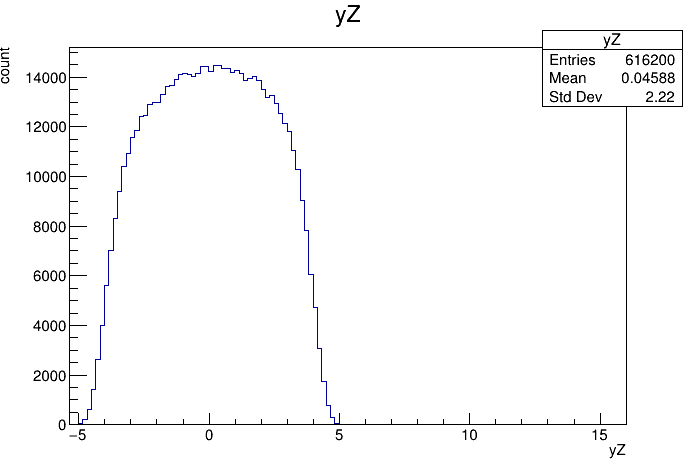

In [8]:
c = ROOT.TCanvas("canvas")
hist.Draw("hist")
c.Draw()

In [7]:
ROOT.gInterpreter.Declare("""
std::pair<TVector3, TVector3> csBoostedProtons(TLorentzVector dilepton) {
    float protonMass = 0.938272;
    float energy = 6500;
    int zsign = dilepton.Z() > 0 ? 1 : -1;
    TLorentzVector proton1(0., 0., zsign*energy, hypot(energy, protonMass));
    TLorentzVector proton2(0., 0., -1*zsign*energy, hypot(energy, protonMass));
    proton1.Boost(-1*dilepton.BoostVector());
    proton2.Boost(-1*dilepton.BoostVector());
    return std::make_pair<TVector3, TVector3>(proton1.Vect(), proton2.Vect());
}

const TVector3 csframe(TLorentzVector dilepton) {
    std::pair<TVector3, TVector3> protons = csBoostedProtons(dilepton);
    TVector3 csAxis = (protons.first.Unit() - protons.second.Unit()).Unit();
    return csAxis;
}

const TVector3 csframeY(TLorentzVector dilepton) {
    std::pair<TVector3, TVector3> protons = csBoostedProtons(dilepton);
    TVector3 csYAxis = protons.first.Unit().Cross(protons.second.Unit());
    return csYAxis.Unit();
}

const TVector3 csframeX(TLorentzVector dilepton) {
    TVector3 csAxis = csframe(dilepton);
    TVector3 csYAxis = csframeY(dilepton);
    TVector3 csXAxis = csYAxis.Cross(csAxis);
    return csXAxis.Unit();
}

float cosThetaCS(ROOT::Math::PtEtaPhiMVector lplus, ROOT::Math::PtEtaPhiMVector lminus) {
    ROOT::Math::PtEtaPhiMVector dilepton = lplus + lminus;
    TLorentzVector dilep(dilepton.X(), dilepton.Y(), dilepton.Z(), dilepton.T());
    TLorentzVector boostedLep(lplus.X(), lplus.Y(), lplus.Z(), lplus.T());
    boostedLep.Boost(-1*dilep.BoostVector());
    const TVector3 csFrame = csframe(dilep);
    return cos(boostedLep.Angle(csFrame));
}

float phiCS(ROOT::Math::PtEtaPhiMVector lplus, ROOT::Math::PtEtaPhiMVector lminus) {
    ROOT::Math::PtEtaPhiMVector dilepton = lplus + lminus;
    TLorentzVector dilep(dilepton.X(), dilepton.Y(), dilepton.Z(), dilepton.T());
    TLorentzVector boostedLep(lplus.X(), lplus.Y(), lplus.Z(), lplus.T());
    boostedLep.Boost(-1*dilep.BoostVector());
    const TVector3 csFrameX = csframeX(dilep);
    const TVector3 csFrameY = csframeY(dilep);
    float phi = atan2(boostedLep.Vect()*csFrameY, boostedLep.Vect()*csFrameX);
    return phi >= 0 ? phi : phi + 2*M_PI;
}
""")

True

In [43]:
tmpdf2 = dfz.Define("pmup", "LHEPart_pdgId[0] < 0 ? pmu1 : pmu2")
tmpdf2 = tmpdf2.Define("pmum", "LHEPart_pdgId[0] > 0 ? pmu1 : pmu2")
tmpdf2 = tmpdf2.Define("pmumpt", "pmum.Pt()")

In [44]:
dfcs = tmpdf2.Define("costcs", "cosThetaCS(pmup, pmum)")
dfcs = dfcs.Define("phics", "phiCS(pmup, pmum)")

In [12]:
histcs = dfcs.Histo1D("costcs")

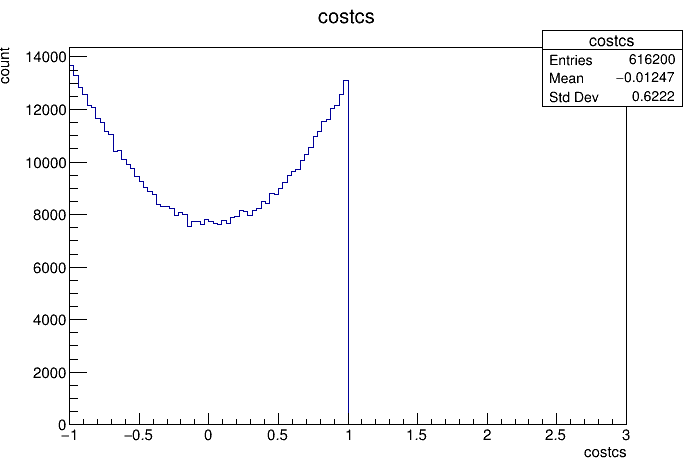

In [13]:
canvas = ROOT.TCanvas("canvas")
histcs.Draw()
canvas.Draw()

In [14]:
histcs = dfcs.Histo1D("phics")

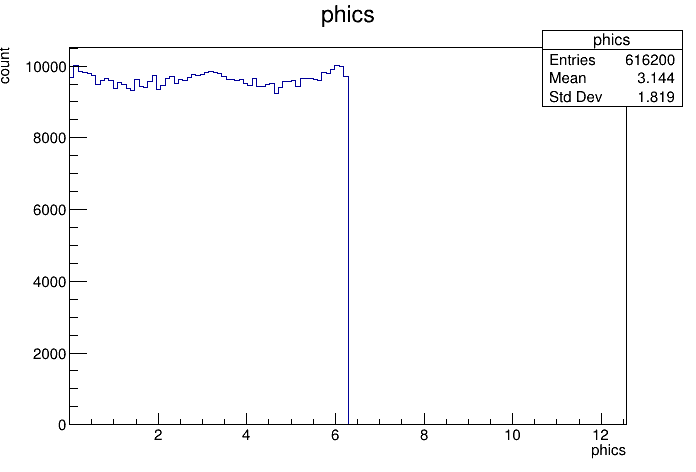

In [15]:
canvas = ROOT.TCanvas("canvas")
histcs.Draw()
canvas.Draw()

In [45]:
var_y  = 'abs(yZ)'
var_pt = 'ptZ'
var_cos = 'costcs'
var_phi = 'phics'

term_const = '(1.+{cost}*{cost})'.format(cost=var_cos)
term_a0    = '(1.-3.*{cost}*{cost})'                                        .format (cost=var_cos)
term_a1    = 'TMath::Sin(2.*TMath::ACos({cost})) * TMath::Cos({phi})'  .format (cost=var_cos,phi=var_phi)
term_a2    = 'TMath::Sin(TMath::ACos({cost}))*TMath::Sin(TMath::ACos({cost}))*TMath::Cos(2.*{phi})'  .format (cost=var_cos,phi=var_phi)
term_a3    = 'TMath::Sin(TMath::ACos({cost}))*TMath::Cos({phi})'       .format (cost=var_cos,phi=var_phi)
term_a4    = '{cost}'                                                  .format (cost=var_cos)
term_a5    = 'TMath::Sin(TMath::ACos({cost}))*TMath::Sin(TMath::ACos({cost})) * TMath::Sin(2.*{phi})'.format (cost=var_cos,phi=var_phi)
term_a6    = 'TMath::Sin(2.*TMath::ACos({cost})) * TMath::Sin({phi})'  .format (cost=var_cos,phi=var_phi)
term_a7    = 'TMath::Sin(TMath::ACos({cost})) * TMath::Sin({phi})'     .format (cost=var_cos,phi=var_phi)

In [46]:
dfang = dfcs.Define("a0", term_a0)
dfang = dfang.Define("a1", term_a1)
dfang = dfang.Define("a2", term_a2)
dfang = dfang.Define("a3", term_a3)
dfang = dfang.Define("a4", term_a4)
dfang = dfang.Define("a5", term_a5)
dfang = dfang.Define("a6", term_a6)
dfang = dfang.Define("a7", term_a7)

In [18]:
hista0 = dfang.Histo1D("a0")
hista1 = dfang.Histo1D("a1")
hista2 = dfang.Histo1D("a2")
hista3 = dfang.Histo1D("a3")
hista4 = dfang.Histo1D("a4")
hista5 = dfang.Histo1D("a5")
hista6 = dfang.Histo1D("a6")
hista7 = dfang.Histo1D("a7")

In [19]:
hista0ptZ = dfang.Histo2D(("a0ptZ", "a0 vs. ptZ", 100, -2, 1, 100, 0,  50), "a0", "ptZ")

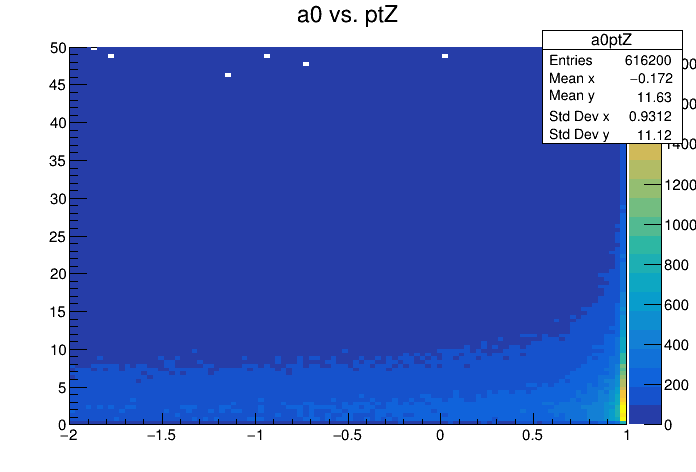

In [20]:
canvas = ROOT.TCanvas("canvas")
hista0ptZ.Draw("colz")
canvas.Draw()

In [25]:
hista4yZ = dfang.Histo2D(("a4yZ", "a4 vs. yZ", 100, -1, 1, 40, -5,  5), "a4", "yZ")

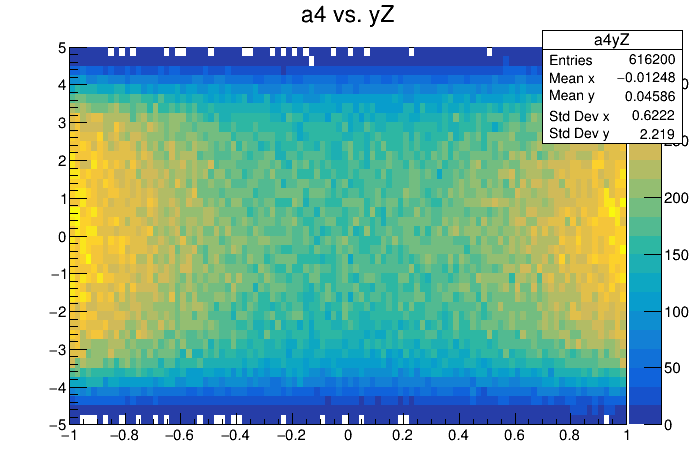

In [26]:
canvas = ROOT.TCanvas("canvas")
hista4yZ.Draw("colz")
canvas.Draw()

In [48]:
cols  = ROOT.RDFDetail.ColumnNames_t()
for c in ["costcs", "phics", "yZ", "ptZ", "mZ", "phiZ", "genWeight"]:
    cols.push_back(c)
dfang.Snapshot("Events", "test.root", cols)

<ROOT.ROOT::RDF::RResultPtr<ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> > object at 0xefcf840>

In [26]:
ROOT.std.vector("string")(["test", "test2"])

TypeError: none of the 9 overloaded methods succeeded. Full details:
  vector<string>::vector<string>() =>
    takes at most 0 arguments (1 given)
  vector<string>::vector<string>(const allocator<string>& __a) =>
    could not convert argument 1
  vector<string>::vector<string>(unsigned long __n, const allocator<string>& __a = std::vector<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::allocator<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > >::allocator_type()) =>
    could not convert argument 1 (an integer is required)
  vector<string>::vector<string>(unsigned long __n, const string& __value, const allocator<string>& __a = std::vector<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::allocator<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > >::allocator_type()) =>
    takes at least 2 arguments (1 given)
  vector<string>::vector<string>(const vector<string>& __x) =>
    could not convert argument 1
  vector<string>::vector<string>(vector<string>&& __x) =>
    could not convert argument 1 (this method can not (yet) be called)
  vector<string>::vector<string>(const vector<string>& __x, const allocator<string>& __a) =>
    takes at least 2 arguments (1 given)
  vector<string>::vector<string>(vector<string>&& __rv, const allocator<string>& __m) =>
    takes at least 2 arguments (1 given)
  vector<string>::vector<string>(initializer_list<string> __l, const allocator<string>& __a = std::vector<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::allocator<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > >::allocator_type()) =>
    could not convert argument 1